In [1]:
!pip install  gdown 
!pip install torchinfo

In [2]:
# https://drive.google.com/file/d/1YVWVe-vAXDtgfali9Y3-TmjauoC-SCOD/view?usp=sharing

!gdown https://drive.google.com/uc?id=1YVWVe-vAXDtgfali9Y3-TmjauoC-SCOD

Downloading...
From (original): https://drive.google.com/uc?id=1YVWVe-vAXDtgfali9Y3-TmjauoC-SCOD
From (redirected): https://drive.google.com/uc?id=1YVWVe-vAXDtgfali9Y3-TmjauoC-SCOD&confirm=t&uuid=efb328f5-c61b-445c-8b21-9a342ca9aa74
To: /kaggle/working/PCOS.zip
100%|████████████████████████████████████████| 391M/391M [00:06<00:00, 57.9MB/s]


In [3]:
import zipfile

zip_file = zipfile.ZipFile('/kaggle/working/PCOS.zip', 'r')
zip_file.extractall('/kaggle/working')
zip_file.close()

In [5]:
import os

pcos = []
no_pcos = []

# for i in os.listdir('/kaggle/working/PCOS/infected'):
#     print(i)

In [7]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset

# Constants

NUM_EPOCHS = 20
DATASET_PATH = '/kaggle/working/PCOS'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
dataset = datasets.ImageFolder(root=DATASET_PATH, transform=train_transform)

# Define the number of images to use
subset_size = 5000

# Randomly select 5000 images from the dataset
indices = torch.randperm(len(dataset))[:subset_size]  # Randomly select indices for the subset
subset = Subset(dataset, indices) 

In [12]:
from collections import Counter

# Initialize a Counter to keep track of the labels
label_counter = Counter()

# Iterate through the subset to count the labels
for idx in indices:
    _, label = dataset[idx]  # Get the label for the given index
    label_counter[label] += 1

# Map label indices back to their class names
class_counts = {dataset.classes[label]: count for label, count in label_counter.items()}

# Print the results
print("Class counts in the subset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")


Class counts in the subset:
noninfected: 2142
infected: 2858


In [10]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),            # Resize all images to 128x128
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=15),   # Randomly rotate images by ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation by 10% of the image size
    # transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.2)),  # Apply Gaussian blur with random sigma
    transforms.ToTensor(),                   # Convert image to PyTorch tensor
    transforms.Normalize([0.5], [0.5])       # Normalize images to [-1, 1]
])

In [7]:
# 5000
dataset = datasets.ImageFolder(root=DATASET_PATH, transform=train_transform)

# Define the number of images to use
subset_size = 5000

# Randomly select 5000 images from the dataset
indices = torch.randperm(len(dataset))[:subset_size]  # Randomly select indices for the subset
subset = Subset(dataset, indices) 

# Define train-test split ratio
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Calculate sizes for training and testing sets
train_size = int(train_ratio * subset_size)
test_size = subset_size - train_size

# Split the subset into training and testing datasets
train_dataset, test_dataset = random_split(subset, [train_size, test_size])

# Create DataLoaders for each subset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print subset sizes
print(f"Total dataset size: {len(dataset)}")
print(f"Subset size: {subset_size}")
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

Total dataset size: 11784
Subset size: 5000
Training set size: 4000
Testing set size: 1000


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OptimizedModel(nn.Module):
    def __init__(self):
        super(OptimizedModel, self).__init__()

        # Conv Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Reduce channels to 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

        # Conv Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        # Conv Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        # Additional layers for skip connections
        self.extra_a = nn.Conv2d(3, 32, kernel_size=1, stride=1)
        self.extra_b = nn.Conv2d(32, 64, kernel_size=1, stride=1)

        # Global Pooling and Fully connected layers
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling
            nn.Flatten(),                  # Flatten: 128 -> 128
            nn.Linear(128, 128),           # Reduce dense layer size
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 2)              # Output layer
        )

    def forward(self, x):
        # Pass through Conv Block 1
        a = x
        x = self.conv1(x)
        b = x

        # Pass through Conv Block 2
        a = self.extra_a(a)
        x = b + a
        x = self.conv2(x)
        d = x

        a = self.extra_b(a)
        b = self.extra_b(b)
        d = F.interpolate(d, size=(128, 128), mode='bilinear', align_corners=False)

        x = a + b + d

        x = self.conv3(x)
        x = self.fc(x)
        return x


In [9]:
from torchinfo import summary
model = OptimizedModel().to(device)
summary(model, input_size=(32, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
OptimizedModel                           [32, 2]                   --
├─Sequential: 1-1                        [32, 32, 128, 128]        --
│    └─Conv2d: 2-1                       [32, 32, 128, 128]        896
│    └─ReLU: 2-2                         [32, 32, 128, 128]        --
│    └─BatchNorm2d: 2-3                  [32, 32, 128, 128]        64
│    └─Conv2d: 2-4                       [32, 32, 128, 128]        9,248
│    └─ReLU: 2-5                         [32, 32, 128, 128]        --
│    └─BatchNorm2d: 2-6                  [32, 32, 128, 128]        64
├─Conv2d: 1-2                            [32, 32, 128, 128]        128
├─Sequential: 1-3                        [32, 64, 64, 64]          --
│    └─Conv2d: 2-7                       [32, 64, 64, 64]          18,496
│    └─ReLU: 2-8                         [32, 64, 64, 64]          --
│    └─BatchNorm2d: 2-9                  [32, 64, 64, 64]          128
│    

In [10]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00001) 

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)


In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Store metrics for visualization
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
all_labels, all_preds = [], []

num_epochs = NUM_EPOCHS

# Training and validation loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    epoch_train_correct = 0
    epoch_train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update train loss
        epoch_train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        epoch_train_correct += (predicted == labels).sum().item()
        epoch_train_total += labels.size(0)

    # Store train loss and accuracy for the epoch
    train_losses.append(epoch_train_loss / len(train_loader))
    train_accuracies.append(epoch_train_correct / epoch_train_total)

    # Testing phase
    model.eval()
    epoch_test_loss = 0
    epoch_test_correct = 0
    epoch_test_total = 0

    # Clear all_labels and all_preds at the beginning of the testing phase
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Update test loss
            epoch_test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            epoch_test_correct += (predicted == labels).sum().item()
            epoch_test_total += labels.size(0)

            # Collect labels and predictions for confusion matrix
            all_labels.append(labels.cpu())
            all_preds.append(predicted.cpu())

    # Store test loss and accuracy for the epoch
    test_losses.append(epoch_test_loss / len(test_loader))
    test_accuracies.append(epoch_test_correct / epoch_test_total)

    # Print metrics for the current epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}")

    # Update the learning rate using the scheduler (monitor validation accuracy)
    scheduler.step(test_accuracies[-1])  # Pass validation accuracy to the scheduler



Epoch [1/20], Train Loss: 0.4215, Train Accuracy: 0.8343, Test Loss: 0.2977, Test Accuracy: 0.9060
Epoch [2/20], Train Loss: 0.2558, Train Accuracy: 0.8970, Test Loss: 0.2389, Test Accuracy: 0.8960
Epoch [3/20], Train Loss: 0.2156, Train Accuracy: 0.9123, Test Loss: 0.3161, Test Accuracy: 0.8490
Epoch [4/20], Train Loss: 0.1876, Train Accuracy: 0.9300, Test Loss: 0.2138, Test Accuracy: 0.8980
Epoch [5/20], Train Loss: 0.1824, Train Accuracy: 0.9237, Test Loss: 0.2374, Test Accuracy: 0.8920
Epoch [6/20], Train Loss: 0.1604, Train Accuracy: 0.9350, Test Loss: 0.1967, Test Accuracy: 0.9090
Epoch [7/20], Train Loss: 0.1501, Train Accuracy: 0.9413, Test Loss: 0.1878, Test Accuracy: 0.9240
Epoch [8/20], Train Loss: 0.1487, Train Accuracy: 0.9423, Test Loss: 0.1811, Test Accuracy: 0.9250
Epoch [9/20], Train Loss: 0.1510, Train Accuracy: 0.9375, Test Loss: 0.2095, Test Accuracy: 0.9120
Epoch [10/20], Train Loss: 0.1395, Train Accuracy: 0.9430, Test Loss: 0.1744, Test Accuracy: 0.9340
Epoch [11

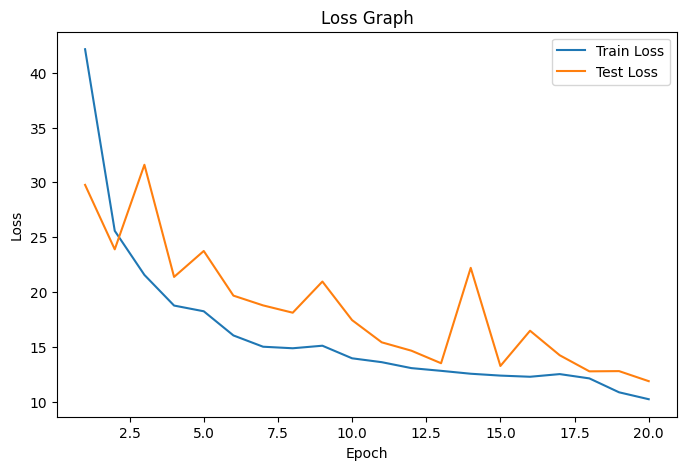

In [12]:
train_loss_percent = [acc * 100 for acc in train_losses]
test_loss_percent = [acc * 100 for acc in test_losses]

# Loss graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_loss_percent, label="Train Loss")
plt.plot(range(1, num_epochs + 1), test_loss_percent, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Graph")
plt.legend()
# plt.yticks(range(73, 75, 2))
plt.show()

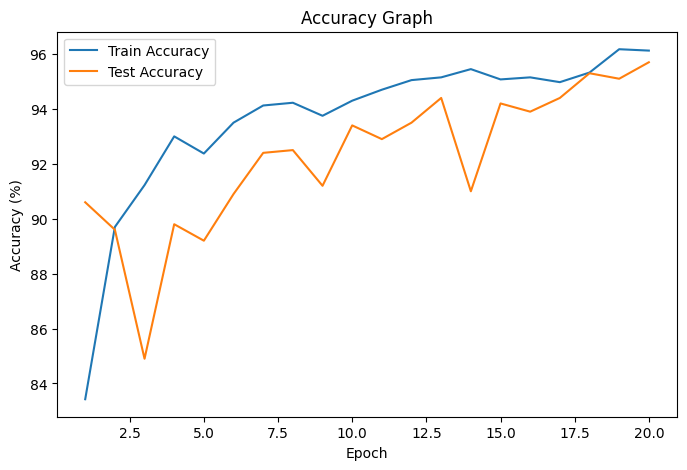

In [13]:
train_accuracies_percent = [acc * 100 for acc in train_accuracies]
test_accuracies_percent = [acc * 100 for acc in test_accuracies]

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies_percent, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies_percent, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Graph")
plt.legend()
plt.show()

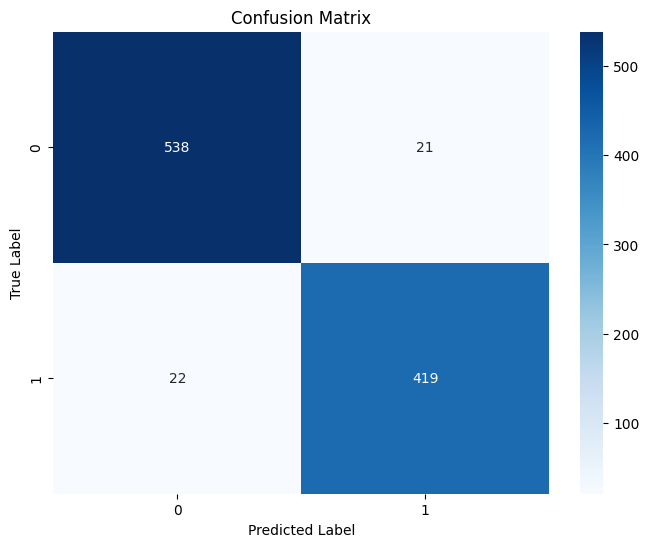

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert collected labels and predictions to tensors
all_labels = torch.cat(all_labels).numpy()
all_preds = torch.cat(all_preds).numpy()

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [15]:
import numpy as np
from sklearn.metrics import classification_report

# Convert all_preds to class labels
# all_preds = np.argmax(all_preds, axis=1)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))



Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       559
           1       0.95      0.95      0.95       441

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

NameError: name 'all_probs' is not defined